### Random forest classification on a sliding window (20 mins)

We start by training on the mean over 20 channels as normal, then we retrain on a dataframe containin each of the 
channel features. Might want to use PCA to lower the number of features and make the process faster

In [132]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [133]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [134]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_20/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-18]
    print(fname)
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

skewness
minimum
maximum
abs_energy
cid_ce
median
x_crossing_m
variance
interquartile_range
mean_change
root_mean_square
mean
mean_abs_change
kurtosis


In [135]:
lineCSN_M3['TTime'] = lineCSN_M3.index

In [136]:
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))

2016-08-05T18:07:38.000000Z


In [145]:
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

In [146]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)

In [147]:
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [148]:
channels_to_drop = ['time','channel_75','channel_76','channel_77','channel_78','channel_79','channel_90',
                   'channel_91','channel_92','channel_93','channel_94']
channels_to_drop = ['time']

def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1))
    opdf.columns = ['time',newcolname]
    
    return opdf

def extract_specific_channels(indf,channels_to_drop=None):
    
    newchannames = []
    if channels_to_drop:
        opdf = indf.drop(channels_to_drop,axis=1)
    else:
        opdf = indf
    for name in opdf.columns:
        new_name = "%s_%s" %(name,indf.name)
        newchannames.append(new_name)
        
    newchannames[-1] = "time"
    opdf.columns = newchannames
    
    return opdf
    

In [149]:
indf = extract_mean_over_channels(feature_dfs[0])

In [150]:
for feature_df in feature_dfs[1:]:
    mean_feature = extract_mean_over_channels(feature_df)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [152]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))

In [153]:
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [154]:
cleaned_df = merged_df.dropna()

In [155]:
cleaned_df.head()

,time,mean_skewness,mean_minimum,mean_maximum,mean_abs_energy,mean_cid_ce,mean_median,mean_x_crossing_m,mean_variance,mean_interquartile_range,mean_mean_change,mean_root_mean_square,mean_mean,mean_mean_abs_change,mean_kurtosis,tsince_start,M3_20_Avg_interp,Temphigh_interp
0,2016-08-05T18:17:38.969414Z,-0.102126,-721.212663,721.917871,6.229980e+07,11123.971324,-0.226115,25038.300000,1297.811570,17.748537,0.000073,35.560678,-0.285303,26.133418,55.086154,600.969414,0.202815,27.298932
1,2016-08-05T18:22:38.969779Z,-0.176469,-646.033099,614.683878,4.977081e+07,9806.802398,-0.296379,24711.333333,1036.760648,15.428240,-0.000057,31.809881,-0.347156,22.938461,53.446978,900.969779,0.202685,27.229765
6,2016-08-05T19:48:23.598811Z,-0.023773,-321.296124,343.750739,5.241238e+07,10945.922959,-0.547330,24952.750000,1091.566702,26.150979,0.000110,32.787194,-0.589998,31.651795,7.951195,6045.598811,0.202000,24.576843
7,2016-08-05T19:53:23.598811Z,-0.080877,-709.042281,620.679876,5.879731e+07,11738.559725,-0.592309,25200.950000,1224.536531,27.106439,0.000015,34.713965,-0.619898,33.300734,18.225917,6345.598811,0.201611,24.357676
8,2016-08-05T19:58:23.598811Z,-0.085741,-709.042281,620.679876,5.504165e+07,11315.992374,-0.615109,25282.750000,1146.250556,26.361041,-0.000150,33.518628,-0.638568,32.075065,20.807207,6645.598811,0.201111,24.138510


## Train random forest

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [131]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [32]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [33]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.07932216 0.07502757 0.07264626 0.02577912 0.04755734 0.10880052
 0.13156659 0.02615359 0.09942392 0.060811   0.03624954 0.11106833
 0.05070572 0.07488834]
0.31513684368857564


In [34]:
regr.score(X_test,y_test)

0.3123606682464922

In [35]:
regr_pred = regr.predict(X_test)

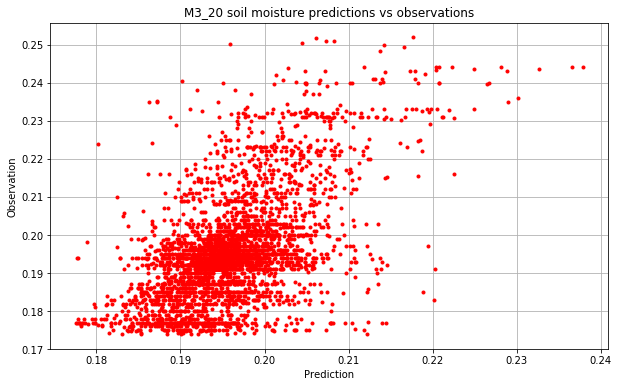

In [36]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

### This is slightly better - it seems that averging over long timseries is a good way preventing noise in the DAS recordings from affecting the results too much

### What about the temperature timseries?

In [157]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [160]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [161]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.06815691 0.06508013 0.06157914 0.0173012  0.03434344 0.1056264
 0.22986218 0.01706309 0.07881565 0.04814048 0.02192402 0.11467565
 0.03802034 0.09941138]
0.47505067791981326


In [163]:
regr_pred = regr.predict(X_test)

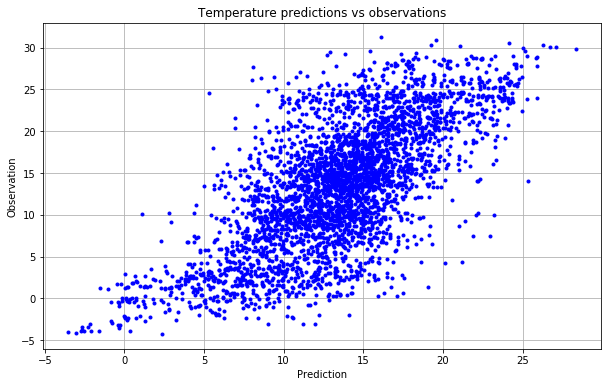

In [164]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

Again, the x crossing rate appears to be the most important feature, suggesting that we need to look into more frequency features. Lets first do this by assessing their ability to operate on some timeseries with known characteristics

What if we decide to train on the un-averged features? 

In [68]:
odf = extract_specific_channels(feature_dfs[0],channels_to_drop = ['channel_75','channel_76','channel_77','channel_78','channel_79','channel_90',
                   'channel_91','channel_92','channel_93','channel_94'])

In [69]:
for feature_df in feature_dfs[1:]:
       
    selected_features_df = extract_specific_channels(feature_df,channels_to_drop=['channel_75','channel_76',
    'channel_77','channel_78','channel_79','channel_90','channel_91','channel_92','channel_93','channel_94'])
    
    merged_df = pd.merge(odf,selected_features_df,on='time')
    odf = merged_df

In [70]:
merged_df.head()

,channel_80_skewness,channel_81_skewness,channel_82_skewness,channel_83_skewness,channel_84_skewness,channel_85_skewness,channel_86_skewness,channel_87_skewness,channel_88_skewness,channel_89_skewness,...,channel_80_kurtosis,channel_81_kurtosis,channel_82_kurtosis,channel_83_kurtosis,channel_84_kurtosis,channel_85_kurtosis,channel_86_kurtosis,channel_87_kurtosis,channel_88_kurtosis,channel_89_kurtosis
0,0.048278,-0.128039,-0.097322,-0.137754,-0.231239,-0.293718,-0.232668,-0.353032,-0.527534,-0.301697,...,46.094891,42.036151,46.544626,60.468981,64.740819,63.238401,64.539676,61.324153,58.138433,50.373765
1,0.043735,-0.150696,-0.092640,-0.168818,NaN,-0.324368,NaN,NaN,-0.581619,-0.343729,...,48.173860,41.576663,47.293230,61.973816,NaN,71.118093,NaN,NaN,63.179471,56.502916
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))

In [73]:
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [74]:
cleaned_df = merged_df.dropna()

In [75]:
cleaned_df.head()

,channel_80_skewness,channel_81_skewness,channel_82_skewness,channel_83_skewness,channel_84_skewness,channel_85_skewness,channel_86_skewness,channel_87_skewness,channel_88_skewness,channel_89_skewness,...,channel_83_kurtosis,channel_84_kurtosis,channel_85_kurtosis,channel_86_kurtosis,channel_87_kurtosis,channel_88_kurtosis,channel_89_kurtosis,tsince_start,M3_20_Avg_interp,Temphigh_interp
0,0.048278,-0.128039,-0.097322,-0.137754,-0.231239,-0.293718,-0.232668,-0.353032,-0.527534,-0.301697,...,60.468981,64.740819,63.238401,64.539676,61.324153,58.138433,50.373765,600.969414,0.202815,27.298932
6,-0.118903,-0.050880,-0.009186,0.006572,-0.031760,-0.125612,-0.038533,-0.003285,-0.001237,0.149073,...,6.865606,7.334290,7.864937,8.046721,7.949246,7.875190,7.534895,6045.598811,0.202000,24.576843
7,-0.528276,-0.247568,-0.013790,-0.122988,-0.340520,-0.361593,-0.424579,-0.366482,-0.244242,0.257232,...,12.284188,16.737169,23.842672,25.545855,22.256889,20.810494,14.902438,6345.598811,0.201611,24.357676
8,-0.561823,-0.228582,0.014711,-0.190491,-0.439092,-0.408359,-0.396740,-0.362315,-0.231320,0.305951,...,14.184019,18.928839,26.318064,27.462911,24.683663,22.355252,16.032041,6645.598811,0.201111,24.138510
9,-0.426245,-0.152872,0.074958,-0.131110,-0.418816,-0.427152,-0.359166,-0.342466,-0.200984,0.280799,...,16.107993,22.077570,29.223632,28.434401,26.310867,23.792393,18.018454,6945.598811,0.201000,23.989423


### Train random forest using all of channels as features 

This will probably take a long time: Could use PCA to try to reduce the number of features to train on?

In [76]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [91]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [92]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.01462327 0.01392137 0.0104756  0.01072374 0.01023498 0.00933982
 0.01119172 0.00988577 0.00854739 0.01143941 0.00804951 0.01023869
 0.00972524 0.00709346 0.00857977 0.00911884 0.00558513 0.0063994
 0.00534381 0.00819704 0.0095898  0.01086719 0.01365803 0.00726483
 0.00660836 0.00663864 0.00540029 0.00634393 0.00587428 0.0074551
 0.00387808 0.00280628 0.00211029 0.00174508 0.00152393 0.00203583
 0.0018649  0.00170608 0.0046317  0.0032017  0.01336474 0.01387765
 0.00632447 0.00492205 0.00233121 0.00344246 0.00302782 0.00251014
 0.00391457 0.00500618 0.01574056 0.00889696 0.00741722 0.00779396
 0.00856427 0.00740103 0.00929486 0.0086252  0.00889769 0.00659671
 0.01271237 0.01241649 0.01395084 0.01632655 0.01174362 0.0260901
 0.02202371 0.02872788 0.01839354 0.02463629 0.00432162 0.00283028
 0.00221919 0.00188581 0.00156457 0.00231271 0.00212856 0.00179999
 0.00615231 0.0039336  0.00746268 0.00483634 0.00537093 0.00479324
 0.00486361 0.00403474 0.00394029 0.0050383  0.01129112 0.0088772

In [93]:
regr.score(X_test,y_test)

0.5307169255747106

In [94]:
regr_pred = regr.predict(X_test)

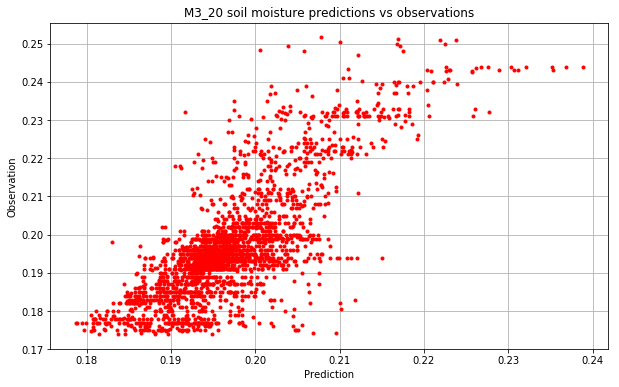

In [95]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

Using more features produces a better result! 

What happens if we use more?

In [97]:
odf = extract_specific_channels(feature_dfs[0])

In [98]:
for feature_df in feature_dfs[1:]:
       
    selected_features_df = extract_specific_channels(feature_df)
    
    merged_df = pd.merge(odf,selected_features_df,on='time')
    odf = merged_df

In [99]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))

In [100]:
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [101]:
cleaned_df = merged_df.dropna()

In [102]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [119]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [120]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.00694721 0.00394511 0.00528584 0.00652337 0.00654592 0.00536356
 0.00535383 0.00479071 0.00563772 0.00617685 0.00460142 0.00486057
 0.00423563 0.00376111 0.00448463 0.0050634  0.00484017 0.00504478
 0.00743546 0.00709358 0.00519995 0.00417275 0.00391148 0.00365333
 0.00285386 0.00281031 0.00544018 0.00358453 0.00454342 0.00455705
 0.00507214 0.00287832 0.00225491 0.00247444 0.00343154 0.00391258
 0.00485286 0.00477734 0.00464706 0.00580396 0.00329405 0.00294672
 0.00290733 0.00326564 0.00286431 0.00284075 0.0045273  0.00609098
 0.00301514 0.00396192 0.00342949 0.0022048  0.00215254 0.0026146
 0.00277363 0.00310734 0.00314957 0.00327272 0.0077051  0.01169972
 0.00159768 0.00134506 0.00848134 0.00282169 0.00157988 0.00223443
 0.00115436 0.00098876 0.00082569 0.00090339 0.0010404  0.00100518
 0.00125693 0.00389591 0.00130977 0.00155981 0.00177022 0.0010089
 0.00128616 0.00237213 0.0051705  0.00717894 0.01208436 0.00602724
 0.00408334 0.00528773 0.00506806 0.00345238 0.00185987 0.001566

In [121]:
regr_pred = regr.predict(X_test)

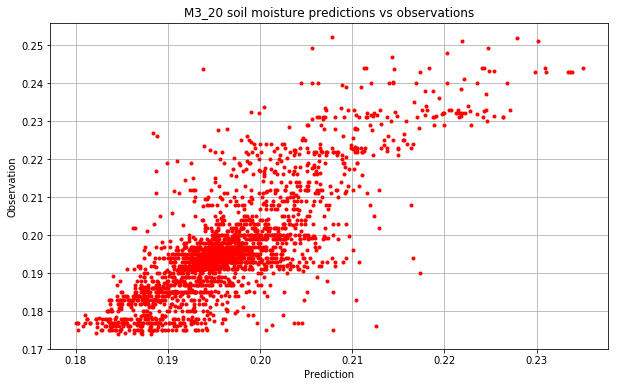

In [122]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

Which column corresponds to the highest importance?

In [117]:
print(cleaned_df.columns[np.argmax(regr.feature_importances_)])

channel_85_x_crossing_m


This makes sense, since channel 85 is closest to the soil moisture probe we're investgating. It suggests that other frequency-related features might be important. 

Its slightly concerning that we have to set the minimum nodes per leaf to 1 here though. Suggests that there are few patterns in the data

### How about the temperature dataset?

In [123]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [124]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [125]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.0066765  0.00634698 0.00466336 0.0076562  0.00475804 0.00588174
 0.00552951 0.00401351 0.00385966 0.00442315 0.00480491 0.0036598
 0.00400243 0.00431444 0.00384353 0.00348905 0.00377395 0.00394023
 0.00449409 0.00538524 0.01188799 0.00362313 0.004271   0.00549136
 0.0032985  0.00465634 0.00407819 0.00271945 0.0026906  0.00255815
 0.00269262 0.00292007 0.00314269 0.00359897 0.00667937 0.00595228
 0.00492737 0.0033925  0.00398557 0.00747877 0.0101154  0.00327273
 0.00333138 0.00423964 0.0035279  0.00415651 0.00416604 0.00298781
 0.00281686 0.00267169 0.00294823 0.00442802 0.00304463 0.00400805
 0.00340472 0.00342154 0.00415631 0.00419284 0.00355898 0.00424811
 0.00138317 0.000687   0.0006701  0.00126498 0.00090805 0.0008324
 0.00087578 0.00100734 0.00062452 0.0004726  0.00083995 0.00158378
 0.00106933 0.00104706 0.00105842 0.00059679 0.00053302 0.00041343
 0.0004894  0.00063784 0.00646784 0.00171235 0.00194852 0.00510453
 0.0014946  0.00169446 0.00184324 0.00295549 0.00130643 0.000993

In [126]:
regr_pred = regr.predict(X_test)

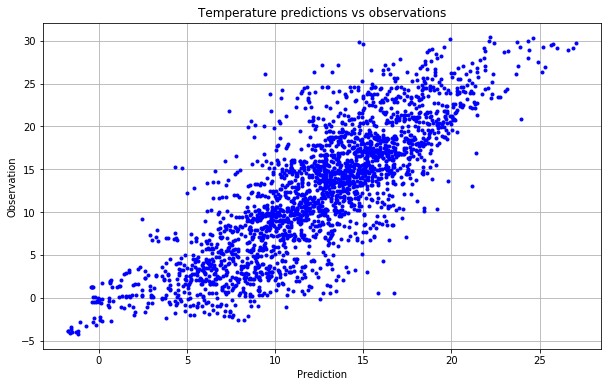

In [129]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

In [128]:
print(cleaned_df.columns[np.argmax(regr.feature_importances_)])

channel_86_x_crossing_m
